#### OpenAI API Setup and Authentication

In [ ]:
import openai
from openai import OpenAI
import pandas as pd
import os
from dotenv import load_dotenv
import json

# Load environment variables
load_dotenv()

class AIDataAnalyst:
    """AI-powered data analysis using OpenAI API"""
    
    def __init__(self, api_key=None):
        # Initialize the OpenAI client (v1.0+ syntax)
        if api_key:
            self.client = OpenAI(api_key=api_key)
        else:
            self.client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
        
        if not self.client.api_key:
            raise ValueError("OpenAI API key not found. Set OPENAI_API_KEY environment variable.")
    
    def test_connection(self):
        """Test OpenAI API connection"""
        try:
            response = self.client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "user", "content": "Say 'API connection successful' if you can read this."}
                ],
                max_tokens=10
            )
            print("✅ OpenAI API connection successful!")
            print(f"Response: {response.choices[0].message.content}")
            return True
        except Exception as e:
            print(f"❌ API connection failed: {e}")
            return False

# Test your setup
try:
    ai_analyst = AIDataAnalyst()
    ai_analyst.test_connection()
except Exception as e:
    print(f"Failed to initialize: {e}")
    print("Make sure your OPENAI_API_KEY is set in your .env file")

#### Basic Data-to-Insights Pattern

Database → AI Pipeline (Direct Connection):

- Raw SQL results are fed directly to an AI model
- The AI processes the data and returns insights in natural language
- Output is typically human-readable text, summaries, or explanations
- Great for immediate understanding and reporting

In [ ]:
def analyze_dataframe_with_ai(df, question="What insights can you provide about this data?"):
    """
    Send DataFrame to AI for analysis using new OpenAI API
    This is the core pattern you'll use everywhere
    """
    
    # Convert DataFrame to a readable format for AI
    data_summary = {
        'shape': df.shape,
        'columns': list(df.columns),
        'sample_data': df.head(3).to_dict('records'),
        'statistics': df.describe().to_dict() if len(df.select_dtypes(include=['number']).columns) > 0 else "No numeric columns"
    }
    
    prompt = f"""
    I have a dataset with the following characteristics:
    
    Shape: {data_summary['shape'][0]} rows, {data_summary['shape'][1]} columns
    Columns: {data_summary['columns']}
    
    Sample data (first 3 rows):
    {json.dumps(data_summary['sample_data'], indent=2, default=str)}
    
    Statistical summary:
    {json.dumps(data_summary['statistics'], indent=2, default=str)}
    
    Question: {question}
    
    Please provide:
    1. Key insights about the data
    2. Notable patterns or trends
    3. Potential business implications
    4. Recommendations for further analysis
    
    Keep your response business-focused and actionable.
    """
    
    try:
        client = OpenAI()  # Uses OPENAI_API_KEY from environment
        
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a senior data analyst who provides clear, actionable insights from business data."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.3  # Lower temperature for more consistent analysis
        )
        
        return response.choices[0].message.content
    
    except Exception as e:
        return f"Error analyzing data: {e}"

# Test with sample data
import sqlite3

# Load some data from your database
def get_sample_sales_data():
    """Get sample data for AI analysis"""
    conn = sqlite3.connect('business_data.db')
    query = """
    SELECT 
        c.region,
        COUNT(o.order_id) as order_count,
        SUM(o.total_amount) as total_revenue,
        AVG(o.total_amount) as avg_order_value
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    WHERE o.status = 'Completed'
    GROUP BY c.region
    ORDER BY total_revenue DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Analyze your sales data with AI
sales_data = get_sample_sales_data()
ai_insights = analyze_dataframe_with_ai(sales_data, "What do these regional sales patterns tell us about our business performance?")
print("AI Analysis of Sales Data:")
print(ai_insights)

### Structured AI Response Processing

#### Structured Analysis (JSON-formatted insights):

- AI processes the data and returns insights in a structured JSON format
- Output follows a predefined schema with consistent field names and data types
- Designed for programmatic consumption rather than human reading
- Enables automated decision-making and integration with other systems

In [ ]:
def get_structured_insights(df, analysis_type="general"):
    """Get structured insights in a consistent format"""
    
    analysis_prompts = {
        "sales": "Focus on revenue trends, customer behavior, and sales performance metrics.",
        "customer": "Focus on customer segmentation, loyalty patterns, and retention insights.",
        "operational": "Focus on efficiency, process optimization, and operational metrics.",
        "general": "Provide a comprehensive business analysis covering all relevant aspects."
    }
    
    data_context = f"""
    Dataset Overview:
    - Rows: {df.shape[0]}
    - Columns: {list(df.columns)}
    - Sample: {df.head(2).to_dict('records')}
    """
    
    prompt = f"""
    {data_context}
    
    Analysis Type: {analysis_type}
    Focus: {analysis_prompts.get(analysis_type, analysis_prompts['general'])}
    
    Please provide insights in this exact JSON format:
    {{
        "key_insights": ["insight 1", "insight 2", "insight 3"],
        "trends": ["trend 1", "trend 2"],
        "recommendations": ["action 1", "action 2"],
        "red_flags": ["concern 1", "concern 2"],
        "next_steps": ["step 1", "step 2"]
    }}
    
    Return only valid JSON, no additional text.
    """
    
    try:
        client = OpenAI()
        
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a data analyst who returns insights in JSON format only."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=400,
            temperature=0.1
        )
        
        # Parse JSON response
        insights = json.loads(response.choices[0].message.content)
        return insights
    
    except json.JSONDecodeError:
        return {"error": "Failed to parse AI response as JSON"}
    except Exception as e:
        return {"error": f"API error: {e}"}

# Test structured analysis
structured_insights = get_structured_insights(sales_data, "sales")
print("Structured AI Insights:")
print(json.dumps(structured_insights, indent=2))

#### Why Use JSON-Formatted Insights?

JSON-formatted insights are particularly powerful because they enable:

#### 1. Automation & Integration

```json
{
 "alert_level": "high",
 "metric": "customer_churn",
 "value": 0.15,
 "threshold_exceeded": true,
 "recommended_actions": ["email_campaign", "retention_offer"]
}

Your application can automatically trigger actions based on these structured fields.

## 2. Consistency & Reliability

- Same data structure every time, regardless of the underlying data
- Easy to validate and process programmatically
- Reduces parsing errors compared to natural language output

## 3. Scalability

- Process hundreds of insights without human intervention
- Build dashboards that update automatically
- Create alerts and notifications based on specific conditions

## 4. Multi-System Integration

- Feed insights into CRM systems, marketing platforms, or business intelligence tools
- Create APIs that other applications can consume
- Enable real-time decision engines


#### SQL Query Enhancement with AI

In [ ]:
def enhance_sql_query_with_ai(query, results_df):
    """Use AI to enhance and explain SQL query results"""
    
    prompt = f"""
    SQL Query:
    {query}
    
    Results:
    {results_df.to_string()}
    
    Please provide:
    1. A business explanation of what this query reveals
    2. Key takeaways from the results
    3. Suggestions for follow-up queries
    4. Potential data quality issues to investigate
    
    Format as a clear business report.
    """
    
    try:
        client = OpenAI()
        
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a senior business analyst who explains SQL results to executives."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=600,
            temperature=0.2
        )
        
        return response.choices[0].message.content
    
    except Exception as e:
        return f"Error enhancing query: {e}"

# Example: Enhance your SQL analysis
sample_query = """
SELECT 
    c.region,
    COUNT(o.order_id) as order_count,
    SUM(o.total_amount) as total_revenue,
    AVG(o.total_amount) as avg_order_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
WHERE o.status = 'Completed'
GROUP BY c.region
ORDER BY total_revenue DESC
"""

enhanced_report = enhance_sql_query_with_ai(sample_query, sales_data)
print("Enhanced SQL Analysis:")
print(enhanced_report)

#### Automated Anomaly Detection

In [ ]:
def detect_anomalies_with_ai(df, metric_column):
    """Use AI to identify anomalies in data"""
    
    # Basic statistical info
    stats = df[metric_column].describe()
    
    prompt = f"""
    I have a dataset with a metric '{metric_column}' with these statistics:
    
    Count: {stats['count']}
    Mean: {stats['mean']:.2f}
    Std: {stats['std']:.2f}
    Min: {stats['min']:.2f}
    Max: {stats['max']:.2f}
    25th percentile: {stats['25%']:.2f}
    75th percentile: {stats['75%']:.2f}
    
    Data sample:
    {df[[metric_column]].head(10).to_string()}
    
    Please identify:
    1. Any statistical anomalies or outliers
    2. Patterns that seem unusual
    3. Potential explanations for anomalies
    4. Whether I should investigate further
    
    Be specific about which values look suspicious and why.
    """
    
    try:
        client = OpenAI()
        
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a statistical analyst expert at identifying data anomalies."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=400,
            temperature=0.2
        )
        
        return response.choices[0].message.content
    
    except Exception as e:
        return f"Error detecting anomalies: {e}"

# Test anomaly detection
anomaly_analysis = detect_anomalies_with_ai(sales_data, 'total_revenue')
print("Anomaly Detection Results:")
print(anomaly_analysis)

### Best Practices
#### Data Preparation

- Ensure clean, properly formatted data
- Include relevant temporal information
- Consider providing business context in prompts

#### Prompt Enhancement
You can improve results by adding:
```python
# Enhanced prompt with business context
prompt = f"""
Context: This is {business_type} revenue data for {time_period}.
Expected patterns: {expected_patterns}
Known events: {special_events}

[Statistical data...]
"""
```
#### Validation Workflow

- Run AI anomaly detection
- Cross-validate with domain experts
- Investigate flagged anomalies
- Update business rules based on findings

#### Cost Considerations

- API calls cost money per token
- Monitor usage for large datasets
- Consider batching for efficiency
- Cache results for repeated analysis

### Integration Opportunities
#### Automated Monitoring
```python
# Daily anomaly check
def daily_anomaly_check():
    today_data = get_daily_metrics()
    anomalies = detect_anomalies_with_ai(today_data, 'key_metric')
    if "investigate further" in anomalies.lower():
        send_alert(anomalies)
```

#### Cost Management and Rate Limiting

In [ ]:
# Cost Management and Rate Limiting
# This section manages API costs and rate limits for responsible usage

import time
from functools import wraps

class AIApiManager:
    """Manage AI API calls with cost tracking and rate limiting"""
    
    def __init__(self, daily_budget=10.0, requests_per_minute=60):
        self.client = OpenAI()
        self.daily_budget = daily_budget
        self.requests_per_minute = requests_per_minute
        self.daily_cost = 0.0
        self.request_times = []
        
        # Updated costs (as of 2024)
        self.costs = {
            'gpt-3.5-turbo': {'input': 0.0015, 'output': 0.002},  # per 1K tokens
            'gpt-4': {'input': 0.03, 'output': 0.06},
            'gpt-4-turbo': {'input': 0.01, 'output': 0.03}
        }
    
    def estimate_cost(self, prompt, response, model='gpt-3.5-turbo'):
        """Estimate cost of API call"""
        # Rough estimation: 1 token ≈ 4 characters
        input_tokens = len(prompt) / 4
        output_tokens = len(response) / 4
        
        input_cost = (input_tokens / 1000) * self.costs[model]['input']
        output_cost = (output_tokens / 1000) * self.costs[model]['output']
        
        return input_cost + output_cost
    
    def check_rate_limit(self):
        """Check if we're within rate limits"""
        now = time.time()
        # Remove requests older than 1 minute
        self.request_times = [t for t in self.request_times if now - t < 60]
        
        if len(self.request_times) >= self.requests_per_minute:
            sleep_time = 60 - (now - self.request_times[0])
            print(f"Rate limit reached. Sleeping for {sleep_time:.1f} seconds...")
            time.sleep(sleep_time)
        
        self.request_times.append(now)
    
    def check_budget(self, estimated_cost):
        """Check if request is within budget"""
        if self.daily_cost + estimated_cost > self.daily_budget:
            raise Exception(f"Daily budget exceeded. Current: ${self.daily_cost:.3f}, Budget: ${self.daily_budget:.3f}")
    
    def managed_api_call(self, prompt, model='gpt-3.5-turbo', max_tokens=500):
        """Make API call with management"""
        self.check_rate_limit()
        
        # Estimate cost before calling
        estimated_cost = self.estimate_cost(prompt, "x" * max_tokens, model)
        self.check_budget(estimated_cost)
        
        try:
            response = self.client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                max_tokens=max_tokens,
                temperature=0.3
            )
            
            result = response.choices[0].message.content
            actual_cost = self.estimate_cost(prompt, result, model)
            self.daily_cost += actual_cost
            
            print(f"API call cost: ${actual_cost:.4f}, Daily total: ${self.daily_cost:.4f}")
            return result
            
        except Exception as e:
            print(f"API call failed: {e}")
            return None

# Example usage
api_manager = AIApiManager(daily_budget=5.0)  # $5 daily budget

def analyze_with_budget_control(df, question):
    """Analyze data with cost control"""
    data_summary = f"Data shape: {df.shape}, Columns: {list(df.columns)}, Sample: {df.head(2).to_dict()}"
    prompt = f"Data: {data_summary}\nQuestion: {question}\nProvide key insights in 3-4 sentences."
    
    return api_manager.managed_api_call(prompt, max_tokens=200)

# Test budget-controlled analysis
budget_analysis = analyze_with_budget_control(sales_data, "What are the key regional performance differences?")
if budget_analysis:
    print("Budget-Controlled Analysis:")
    print(budget_analysis)

#### Helpful: Database Health Monitor

In [ ]:
# Simple AI-powered data health check function
# This function checks the health of a DataFrame and provides recommendations
def simple_ai_health_check(df, table_name):
    """Simple AI-powered data health check"""
    
    prompt = f"""
    I have a table called '{table_name}' with this data:
    
    Shape: {df.shape[0]} rows, {df.shape[1]} columns
    Columns: {list(df.columns)}
    
    Sample data:
    {df.head(5).to_string()}
    
    Data types:
    {df.dtypes.to_string()}
    
    Missing values:
    {df.isnull().sum().to_string()}
    
    Please assess the health of this data and provide:
    1. Overall data quality assessment
    2. Any potential issues you notice
    3. Recommendations for improvement
    4. Suggested data validation checks
    
    Keep it practical and actionable.
    """
    
    try:
        client = OpenAI()
        
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a data quality expert who identifies issues and provides practical recommendations."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=400,
            temperature=0.2
        )
        
        return response.choices[0].message.content
    
    except Exception as e:
        return f"Error in health check: {e}"

# Test health check
health_report = simple_ai_health_check(sales_data, "regional_sales")
print("Data Health Check:")
print(health_report)

### Exercise 1: SQL Report Enhancer

Create a function that takes any SQL query result and enhances it with AI insights.

I chose to use the advanced analytics SQL query from Day 10 with some updated settings for this exercise.

The insights were interesting and gave some ideas for additional analysis.

I used about 4,000 tokens for testing which cost around $0.002 per token for input and $0.004 per output token. (Note - the $3.34 total includes other Flowise project usages)

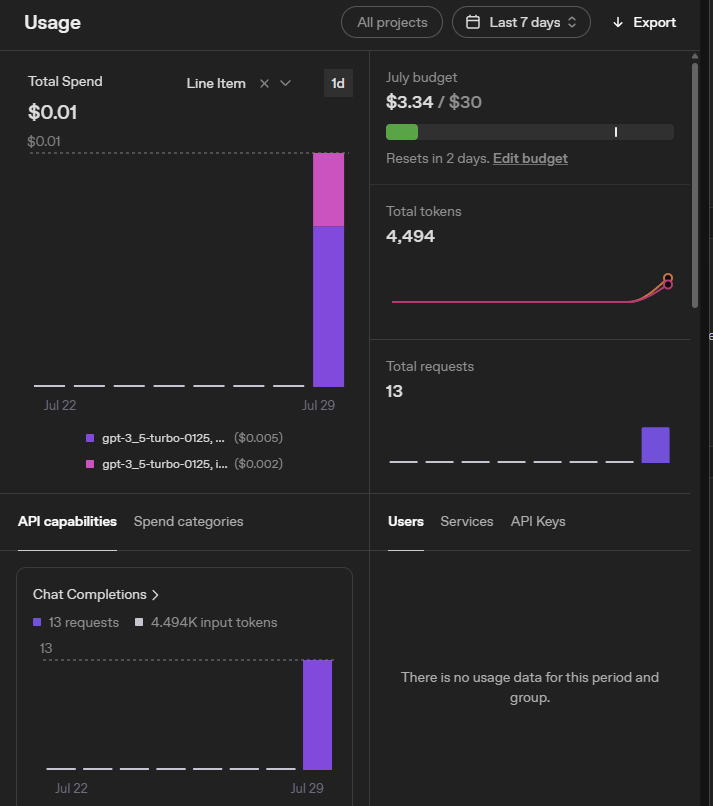

In [ ]:
import openai
from openai import OpenAI
import pandas as pd
import os
from dotenv import load_dotenv
import json
from sqlalchemy import create_engine, text
import urllib.parse

# Load environment variables
load_dotenv()

class SQLServerConnection:
    """SQL Server connection class"""
    def __init__(self, server, database, trusted_connection=True, username=None, password=None):
        self.server = server
        self.database = database
        self.trusted_connection = trusted_connection
        self.username = username
        self.password = password
        self.engine = None
        
    def connect(self):
        """Establish connection to SQL Server"""
        try:
            if self.trusted_connection:
                # Windows Authentication
                connection_string = f"mssql+pyodbc://{self.server}/{self.database}?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
            else:
                # SQL Server Authentication
                connection_string = f"mssql+pyodbc://{self.username}:{self.password}@{self.server}/{self.database}?driver=ODBC+Driver+17+for+SQL+Server"
            
            self.engine = create_engine(connection_string)
            # Test connection
            with self.engine.connect() as conn:
                conn.execute(text("SELECT 1"))
            print(f"Successfully connected to {self.server}/{self.database}")
            return True
        except Exception as e:
            print(f"Failed to connect to database: {e}")
            return False
    
    def execute_query(self, query):
        """Execute SQL query and return DataFrame"""
        try:
            if self.engine is None:
                print("No database connection. Call connect() first.")
                return None
            
            df = pd.read_sql(query, self.engine)
            return df
        except Exception as e:
            print(f"Error executing query: {e}")
            return None
    
    def close(self):
        """Close database connection"""
        if self.engine:
            self.engine.dispose()
            print("Database connection closed.")

def analyze_dataframe_with_ai(df, question="What insights can you provide about this data?"):
    """Send DataFrame to AI for analysis using OpenAI API"""
    
    # Convert DataFrame to a readable format for AI
    data_summary = {
        'shape': df.shape,
        'columns': list(df.columns),
        'sample_data': df.head(3).to_dict('records'),
        'statistics': df.describe().to_dict() if len(df.select_dtypes(include=['number']).columns) > 0 else "No numeric columns"
    }
    
    prompt = f"""
    I have a dataset with the following characteristics:
    
    Shape: {data_summary['shape'][0]} rows, {data_summary['shape'][1]} columns
    Columns: {data_summary['columns']}
    
    Sample data (first 3 rows):
    {json.dumps(data_summary['sample_data'], indent=2, default=str)}
    
    Statistical summary:
    {json.dumps(data_summary['statistics'], indent=2, default=str)}
    
    Question: {question}
    
    Please provide:
    1. Key insights about the data
    2. Notable patterns or trends
    3. Potential business implications
    4. Recommendations for further analysis
    
    Keep your response business-focused and actionable.
    """
    
    try:
        client = OpenAI()  # Uses OPENAI_API_KEY from environment
        
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a senior data analyst who provides clear, actionable insights from business data."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.3
        )
        
        return response.choices[0].message.content
    
    except Exception as e:
        return f"Error analyzing data: {e}"

def create_ai_enhanced_report(query, df, report_title="Data Analysis Report"):
    """Create comprehensive AI-enhanced report"""
    
    # Get AI insights
    insights = analyze_dataframe_with_ai(df, "Provide executive-level insights about this data")
    
    # Generate report
    report = f"""
# {report_title}
Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}

## Data Overview
- Rows: {df.shape[0]}
- Columns: {df.shape[1]}
- Columns: {', '.join(df.columns)}

## AI Analysis
{insights}

## Data Summary
{df.describe() if len(df.select_dtypes(include=['number']).columns) > 0 else 'No numeric data to summarize'}
"""
    
    return report

def sql_server_advanced_analytics():
    """Perform advanced analytics on SQL Server data"""
    
    sql_server = SQLServerConnection(
        server='localhost\\SQLEXPRESS',
        database='WideWorldImporters',  
        trusted_connection=True
    )
    
    if sql_server.connect():
        # Complex analytics query using SQL Server features
        analytics_query = """
        WITH CustomerMetrics AS (
            SELECT 
                c.CustomerID,
                c.CustomerName,
                COUNT(o.OrderID) as TotalOrders,
                ISNULL(SUM(ol.PickedQuantity * ol.UnitPrice), 0) as TotalRevenue,
                ISNULL(AVG(ol.PickedQuantity * ol.UnitPrice), 0) as AvgOrderValue,
                MIN(o.OrderDate) as FirstOrderDate,
                MAX(o.OrderDate) as LastOrderDate,
                DATEDIFF(day, MIN(o.OrderDate), MAX(o.OrderDate)) as CustomerLifespanDays
            FROM Sales.Customers c
            LEFT JOIN Sales.Orders o ON c.CustomerID = o.CustomerID
            LEFT JOIN Sales.OrderLines ol ON o.OrderID = ol.OrderID
            GROUP BY c.CustomerID, c.CustomerName
        ),
        CustomerSegments AS (
            SELECT 
                *,
                CASE 
                    WHEN TotalRevenue > 200000 THEN 'Premium'
                    WHEN TotalRevenue > 100000 THEN 'Standard'
                    ELSE 'Basic'
                END as CustomerSegment,
                CASE 
                    WHEN CustomerLifespanDays > 0 
                    THEN TotalRevenue / CustomerLifespanDays * 365 
                    ELSE TotalRevenue 
                END as EstimatedAnnualValue
            FROM CustomerMetrics
        )
        SELECT 
            CustomerSegment,
            COUNT(*) as CustomerCount,
            AVG(TotalRevenue) as AvgRevenue,
            AVG(EstimatedAnnualValue) as AvgAnnualValue,
            SUM(TotalRevenue) as SegmentRevenue
        FROM CustomerSegments
        WHERE TotalOrders > 0  -- Only customers with orders
        GROUP BY CustomerSegment
        ORDER BY AvgRevenue DESC
        """
        
        results = sql_server.execute_query(analytics_query)
        if results is not None:
            print("Customer Segment Analysis:")
            print(results)
            
            # Enhanced analysis with pandas
            results['revenue_percentage'] = (results['SegmentRevenue'] / results['SegmentRevenue'].sum()) * 100
            print("\nRevenue Distribution by Segment:")
            print(results[['CustomerSegment', 'revenue_percentage']])
            
            # Generate AI-enhanced report
            report = create_ai_enhanced_report(
                analytics_query, 
                results, 
                "Customer Segmentation Analysis Report"
            )
            print("\n" + "="*50)
            print("AI-ENHANCED REPORT")
            print("="*50)
            print(report)
        
        sql_server.close()
        return results
    else:
        print("Failed to connect to database")
        return None

if __name__ == "__main__":
    print("Running Customer Segmentation Analysis...")
    results = sql_server_advanced_analytics()
    print("\nAnalysis complete!")